# Домашнее задание 2. Кластеризация векторного пространства
Андрей Якубой, БКЛ212

## Входные данные
Входные данные содержатся в файле [HW2_igrat'.txt](https://github.com/dashapopova/CompSem2024/blob/main/HW/HW2_igrat'.txt).
Это глагол и список существительных, которые часто занимают при нем позицию субъекта или объекта. При каждой паре "глагол + существительное" указано, сколько раз они встретились вместе в основном подкорпусе НКРЯ.
> Существительные подбирались следующим образом: в автоматически размеченном и дизамбигуированном основном подкорпусе НКРЯ выделялись случаи, когда за существительным в номинативе или аккузативе непосредственно следует искомый глагол и, наоборот, когда за искомым глаголом непосредственно следует существительное в номинативе или аккузативе; все такие существительные собраны в единый частотный список, из которого в итоговый набор попали все пары, встретившиеся не менее 20 раз.  
**NB!** Можно взять свой датасет, см. пункт 7 в задачах.

## Задачи

**7. (бонус на 9-10)**. Вместо предложенного датасета возьмите свой: выберите предикат и по любому корпусу составьте список существительных - его наиболее частотных аргументов (в списке должно быть около 100 словосочетаний). Максимально четко опишите процедуру подготовки датасета: какой использовался корпус, как был составлен сам список.

В целом, я придерживался той же стратегии, что и авторы оригинального датасета, составляя его в том же формате, не забывая и про частотность.

В качестве объекта исследования я выбрал глагол *пройти*, так как он многозначный, и его разные значения отражает сочетаемость с именами. Кроме прямого значения в качестве глагола движения (*человек прошёл*) он используется и для указания на закончившийся промежуток времени: *прошёл день*, *прошёл год*, *прошло время*. Кроме того, с глаголом сочетаются и имена, обозначающие события: *прошёл урок*, *прошла лекция*, *прошёл концерт*. Есть и другие, более редкие значения, напр. *пройти игру*.

 основном подкорпусе НКРЯ с автоматически снятой омонимией отдельно были проанализированы биграммы: [существительное в номинативе, предшествующее глаголу *пройти* или следующее за ним](https://ruscorpora.ru/s/bqDvD), [существительные в аккузативе, предшествующее глаголу *пройти* или следующее за ним](https://ruscorpora.ru/s/erXwB). Каждая из таблиц биграмм была проанализирована вручную, причём словоформы в биграммах заменялись на леммы, а при встрече другой биграммы с другой словоформой уже записанной леммой или с другим порядком слов просто складывались частотности. Датасет отсортирован по убыванию частотности.

В итоговом датасете, как и в оригинальном, никак не учтён препозитивный или постпозитивный статус существительного, а также объектно-субъектный. Ограничение в 20 на частотность не устанавливалось, потому что в целом употреблений *пройти* в НКРЯ меньше, чем *играть*.

[Датасет](https://github.com/Futyn-Maker/hse-compsem-2024-hw/blob/main/CompSem_HW2_dataset_projti.txt)

In [1]:
!wget https://raw.githubusercontent.com/Futyn-Maker/hse-compsem-2024-hw/main/CompSem_HW2_dataset_projti.txt

--2024-02-21 11:18:09--  https://raw.githubusercontent.com/Futyn-Maker/hse-compsem-2024-hw/main/CompSem_HW2_dataset_projti.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2552 (2.5K) [text/plain]
Saving to: ‘CompSem_HW2_dataset_projti.txt’

CompSem_HW2_dataset 100%[===================>]   2.49K  --.-KB/s    in 0s      

2024-02-21 11:18:09 (20.5 MB/s) - ‘CompSem_HW2_dataset_projti.txt’ saved [2552/2552]



In [2]:
import pandas as pd

data = pd.read_csv("CompSem_HW2_dataset_projti.txt", sep="\t", header=None, names=["pair", "frequency"])
data.head()

,pair,frequency
0,пройти_день,1711
1,пройти_время,1550
2,пройти_год,1492
3,пройти_ночь,602
4,пройти_путь,578


1. Взять [любую предобученную векторную модель для русского языка](http://vectors.nlpl.eu/repository/) и извлечь оттуда вектор для глагола и каждого существительного из списка. [Здесь](https://github.com/dashapopova/CompSem2024/blob/main/CompSem_word2vec_24.ipynb) лежит хендаут по word2vec, который может вам пригодиться.

In [3]:
!wget http://vectors.nlpl.eu/repository/20/220.zip
!unzip 220.zip

--2024-02-21 11:18:09--  http://vectors.nlpl.eu/repository/20/220.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638171816 (609M) [application/zip]
Saving to: ‘220.zip’

220.zip             100%[===================>] 608.61M  24.1MB/s    in 26s     

2024-02-21 11:18:36 (23.5 MB/s) - ‘220.zip’ saved [638171816/638171816]

Archive:  220.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [4]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("model.bin", binary=True)

nouns = data["pair"].apply(lambda x: x.split("_")[1]).unique()
verb = "пройти_VERB"

word_vectors = {"пройти": model[verb]}

for noun in nouns:
    noun_tagged = f"{noun}_NOUN"
    if noun_tagged in model:
        word_vectors[noun] = model[noun_tagged]
    else:
        print(f"{noun_tagged}: слово отсутствует")

2. На основе этих векторов построить репрезентацию для каждой пары «глагол + существительное» с помощью простой аддитивной модели композиции.
> Примечание. Если каждый вектор – это объект типа array в модуле numpy, то можно просто сложить эти два объекта, используя оператор «+».

In [5]:
pair_vectors = {}

for pair in data["pair"]:
    noun = pair.split("_")[1]
    if noun in word_vectors:
        pair_vectors[pair] = word_vectors["пройти"] + word_vectors[noun]

3. Собрать все векторные представления пар в единую матрицу и кластеризовать их двумя способами:
* методом иерархической кластеризации;
* методом К-средних, см. [хендаут](https://github.com/dashapopova/CompSem2024/blob/main/CompSemClustering.ipynb).<br/>
В первом случае количество кластеров определяется автоматически (но задается значение порога t), во втором случае количество кластеров нужно задать вручную.
Возьмите то значение каждого из этих параметров, которое вам кажется наиболее удачным и обоснуйте свое решение (одного-двух предложений будет вполне достаточно).
Все остальные параметры в обоих случаях можно не менять и использовать настройки по умолчанию.

In [6]:
import numpy as np

matrix = np.array(list(pair_vectors.values()))
matrix.shape

(85, 300)

In [7]:
import random

random.seed(42)
np.random.seed(42)

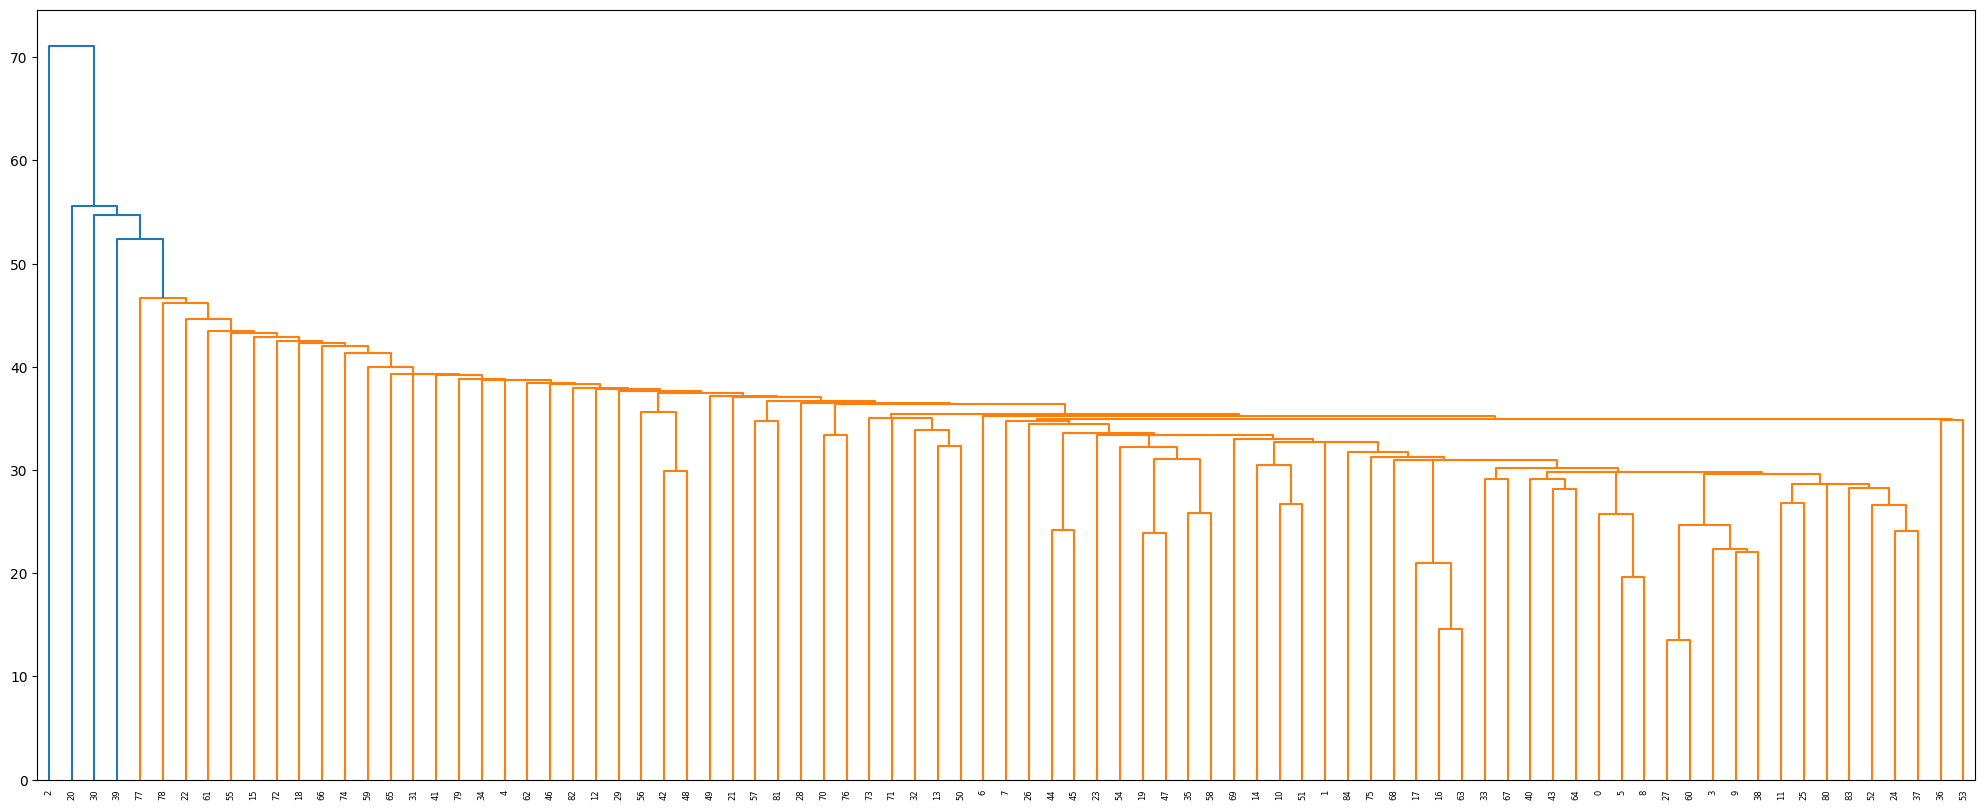

In [8]:
# Иерархическая кластеризация

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

Z = linkage(matrix)

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [9]:
clusters = fcluster(Z, 0.8)
len(set(clusters))

51

51 кластер - это, наверное, много. Однако при установке значения *t* на 1 получается 43 кластера, что, казалось бы, тоже много, но они не очень релевантны. При установке значения ещё больше мы наблюдаем и вовсе только 1 кластер, промежуточных выявить не получилось.

In [10]:
# Метод K средних

from sklearn.cluster import KMeans

K = 4

kmeans = KMeans(n_clusters=K)
kmeans_labels = kmeans.fit_predict(matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Я задал количество кластеров, равное 4 - примерно столько значений имеет глагол *пройти* согласно словарям.

4. Для каждого кластера определите центр и выберите по три элемента, наиболее к нему близких (по метрике косинусной близости).
Центр можно определить как среднее арифметическое среди всех элементов кластера по каждому измерению (например, с помощью метода numpy.mean).
Кластеры, размер которых не превышает двух элементов, не учитывайте совсем.

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def find_cluster_centers(matrix, labels):
    unique_labels = set(labels)
    cluster_info = {}

    for label in unique_labels:
        cluster_indices = np.where(labels == label)[0]
        if len(cluster_indices) > 1:
            cluster_vectors = matrix[cluster_indices]
            center = np.mean(cluster_vectors, axis=0)
            cos_sim = cosine_similarity(cluster_vectors, [center])
            closest_indices = np.argsort(-cos_sim.flatten())[:3]
            cluster_info[label] = (center, cluster_indices[closest_indices])

    return cluster_info

In [12]:
hierarchical_cluster_info = find_cluster_centers(matrix, clusters)
kmeans_cluster_info = find_cluster_centers(matrix, kmeans_labels)

Я поставил ограничение не > 2, а > 1 - потому что в случае с моим датасетом 3 элемента в кластере - это большая редкость.

In [13]:
def format_clusters(data, cluster_info):
    groups = []
    for label, info in cluster_info.items():
        _, closest_indices = info
        phrases = data.iloc[closest_indices]["pair"].values
        groups.append(", ".join(phrases))
    return "\n".join(groups)

In [14]:
hierarchical_groups = format_clusters(data, hierarchical_cluster_info)
hierarchical_groups

'пройти_совещание, пройти_заседание, пройти_конференция\nпройти_голова, пройти_рука\nпройти_дверь, пройти_комната\nпройти_обучение, пройти_занятие, пройти_подготовка\nпройти_половина, пройти_четверть\nпройти_спектакль, пройти_пьеса\nпройти_опера, пройти_балет\nпройти_час, пройти_минута, пройти_сутки\nпройти_лето, пройти_весна, пройти_зима\nпройти_проверка, пройти_обследование\nпройти_вечер, пройти_утро, пройти_ночь\nпройти_презентация, пройти_премьера'

In [15]:
kmeans_groups = format_clusters(data, kmeans_cluster_info)
kmeans_groups

'пройти_гроза, пройти_пора, пройти_ночь\nпройти_техосмотр, пройти_проверка, пройти_подготовка\nпройти_неделя, пройти_месяц, пройти_час\nпройти_спектакль, пройти_опера, пройти_балет'

6. Подготовьте очень краткий (буквально на абзац) анализ результатов. Однородные ли, на ваш взгляд, получились группы? Все ли значения глагола удалось «поймать» и проиллюстрировать?

**NB!** Шаги 4-6 нужно проделать с результатами обеих кластеризаций: и иерархической, и методом К-средних.

В целом: на этом наборе данных и при использовании самой большой на данный момент модели W2V для русского языка кластеризация происходит неплохо. Однако здесь я ожидал, что получится хотя бы выделить кластеры, связанные с промежутками времени и с более агентивным, когда *пройти* выступает в качестве глагола движения - а ещё, возможно, обнаружить группы, связанные с переходными и непереходными значениями. На практике кластеры объединяют скорее близкие значения самих существительных.

* Иерархическая кластеризация: при такой фильтрации, какая существует сейчас, получаются самые адекватные, насколько это вообще возможно, кластеры. При этом их явно должно быть сильно меньше и существующие содержат часто только по два элемента, но при попытке сделать их более плотными с помощью увеличения *t* приводят к уменьшению количества до одного. То, что мы наблюдаем - в основном кластеризация по значению самих существительных: например, хорошо в один кластер объединились *пройти утро*, *пройти день* и *пройти ночь*. Также в одном кластере оказались, например, *пройти обучение* и *пройти занятие*, что говорит о некотором успехе в попытке выделить некоторые из значений глагола. В целом, такие кластеры как *пройти опера* - *пройти спектакль* и *пройти* - *пройти собрание* тоже вполне адекватны, но могли бы быть объединены в один. Итак, здесь проблема в очень мелких кластерах, которые выявляются только на основе векторов самих существительных, особо не учитывая глагол.
* Кластеризация методом *k* средних: сами кластеры выглядят хорошо, в основном благодаря тому, что мы изначально могли задать их нормальное количество. При этом я бы всё равно скорее говорил, что глагол почти никак не вкладывается в получившиеся кластеры, а решают значения существительных - единственный кластер, для которого я бы сделал исключение - *пройти проверку* - *пройти техосмотр* - *пройти проверку* - здесь значение "пройти диагностику" выделяется хорошо. Неплохо выделяется и временное значение (*день*, *неделя*, *час*).

Таким образом, простая аддитивная модель на основе статических эмбеддингов показала себя скорее не очень для задачи кластеризации, если мы хотим выделить отдельные значения глаголов. Получаемые векторы описывают скорее значения существительных, и вектор предиката в это вкладывается слабо. Так может происходить из-за статической сущности эмбеддингов, из-за того, что при сумме мы пытаемся скорее смешать значения двух разных слов, а не получить среднее. Для улучшения можно было бы попробовать другую модель получения вектора словосочетания - усреднения - или каким-нибудь образом указать, какую позицию при предикате занимает существительное.